<a href="https://colab.research.google.com/github/slneha/AIPI590_Fall2025/blob/main/Assignment5/AIPI_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#prerequisite: upload your kaggle.json file to get the dataset from kaggle
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

ERROR: Operation cancelled by user


In [2]:
!kaggle datasets download -d asdasdasasdas/garbage-classification
!unzip garbage-classification.zip -d /content/trashnet

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.17GB/s]
Archive:  garbage-classification.zip
  inflating: /content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard1.jpg  
  inflating: /content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard10.jpg  
  inflating: /content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard100.jpg  
  inflating: /content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard101.jpg  
  inflating: /content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard102.jpg  
  inflating: /content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard103.jpg  
  inflating: /content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard104.jpg  
  inflating: /content/trashnet/Garbage 

In [3]:
!pip -q install torch torchvision pillow numpy opencv-python

In [4]:
import torch, torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np, cv2, os, glob, math
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing for ResNet-50
preproc = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

#the following helper functions were generated by ChatGPT

def load_image(path):
    img = Image.open(path).convert('RGB')
    t = preproc(img).unsqueeze(0)
    return img, t.to(device)

def to_numpy_img(tensor_01CHW):
    t = tensor_01CHW.detach().cpu().squeeze(0)
    t = t.permute(1,2,0).numpy()
    t = (t - t.min()) / (t.max() - t.min() + 1e-8)
    return (t*255).astype(np.uint8)

def overlay_heatmap(rgb, heatmap, alpha=0.35):
    # rgb: HxWx3 (uint8), heatmap: h×w (float in [0,1] or unnormalized)
    H, W = rgb.shape[:2]
    hm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    # resize CAM to img size
    hm = cv2.resize(hm, (W, H), interpolation=cv2.INTER_CUBIC)

    heat = cv2.applyColorMap((hm * 255).astype(np.uint8), cv2.COLORMAP_JET)[:, :, ::-1] / 255.0
    rgbf = rgb.astype(np.float32) / 255.0 # converting rgb to float value
    out = (1 - alpha) * rgbf + alpha * heat
    out = (out / out.max())
    return (out * 255).astype(np.uint8)

def show_side_by_side(img_rgb, maps_dict, cols=3, figsize=(14,8)):
    keys = list(maps_dict.keys())
    rows = math.ceil(len(keys)/cols)
    plt.figure(figsize=figsize)
    for i,k in enumerate(keys,1):
        plt.subplot(rows, cols, i)
        hm = maps_dict[k]
        plt.imshow(overlay_heatmap(img_rgb, hm))
        plt.title(k); plt.axis('off')
    plt.tight_layout(); plt.show()


In [5]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device).eval()

# hook the last conv layer (layer4[-1].conv3)
target_layer = model.layer4[-1].conv3

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 77.4MB/s]


In [6]:
acts = {}
grads = {}

def save_activation(module, inp, out):
    acts['value'] = out.detach()

def save_gradient(module, grad_in, grad_out):
    grads['value'] = grad_out[0].detach()

# register hooks
h1 = target_layer.register_forward_hook(save_activation)
h2 = target_layer.register_full_backward_hook(save_gradient)


In [7]:
def predict_logits(x):
    with torch.no_grad():
        return model(x)

def top_class(logits):
    probs = F.softmax(logits, dim=1)
    conf, idx = probs.max(dim=1)
    return idx.item(), conf.item()


In [8]:
def gradcam(x, class_idx=None, relu=True):
    acts.clear(); grads.clear()
    logits = model(x)
    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()

    # scalar target logit
    score = logits[:, class_idx].sum()
    model.zero_grad()
    score.backward(retain_graph=True)

    A = acts['value'] # [B,C,H,W]
    dYdA = grads['value'] # [B,C,H,W]
    weights = dYdA.mean(dim=(2,3), keepdim=True) # [B,C,1,1]
    cam = (weights * A).sum(dim=1, keepdim=False) # [B,H,W]
    cam = cam.relu() if relu else cam
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam.squeeze(0).cpu().numpy()


In [9]:
def layercam(x, class_idx=None):
    acts.clear(); grads.clear()
    logits = model(x)
    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()
    score = logits[:, class_idx].sum()
    model.zero_grad()
    score.backward(retain_graph=True)

    A = acts['value']                 # [B,C,H,W]
    dYdA = grads['value']             # [B,C,H,W]
    S = (A * dYdA).clamp(min=0).sum(dim=1)  # [B,H,W]
    S = (S - S.min()) / (S.max() - S.min() + 1e-8)
    return S.squeeze(0).cpu().numpy()


In [10]:
def eigencam(x):
    acts.clear(); grads.clear()
    with torch.no_grad():
        _ = model(x)
    A = acts['value'] # [B,C,H,W]
    A1 = A.squeeze(0) # [C,H,W]
    C, H, W = A1.shape
    M = A1.view(C, H*W) # [C, HW]

    U, S, Vt = torch.linalg.svd(M, full_matrices=False)
    pc1 = Vt[0]
    cam = pc1.view(H, W)
    cam = cam - cam.min()
    cam = cam / (cam.max() - cam.min() + 1e-8)
    return cam.cpu().numpy()


Selected images: ['/content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard214.jpg', '/content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard354.jpg', '/content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard314.jpg', '/content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard311.jpg', '/content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard320.jpg']
Image: cardboard214.jpg | Top-1 class index: 615 | conf: 0.058


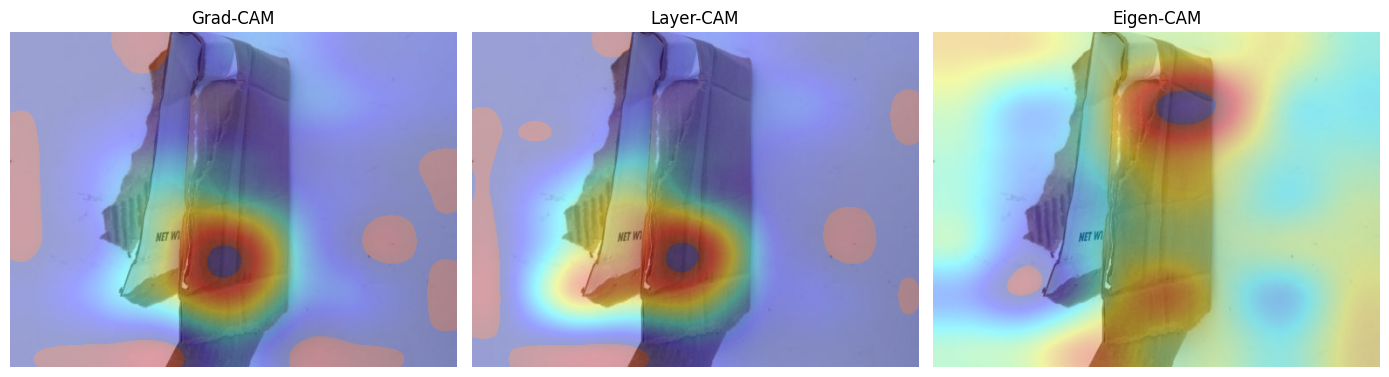

Image: cardboard354.jpg | Top-1 class index: 499 | conf: 0.080


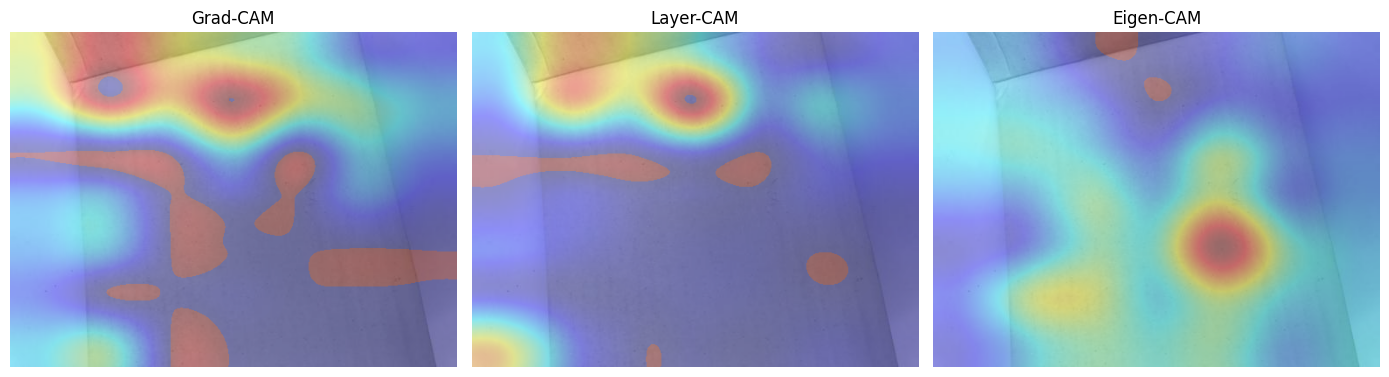

Image: cardboard314.jpg | Top-1 class index: 478 | conf: 0.085


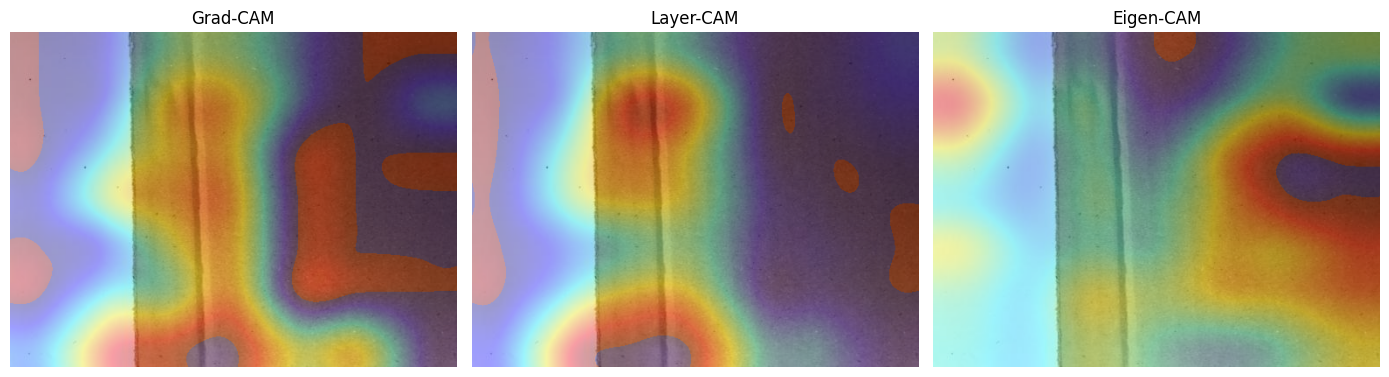

Image: cardboard311.jpg | Top-1 class index: 478 | conf: 0.395


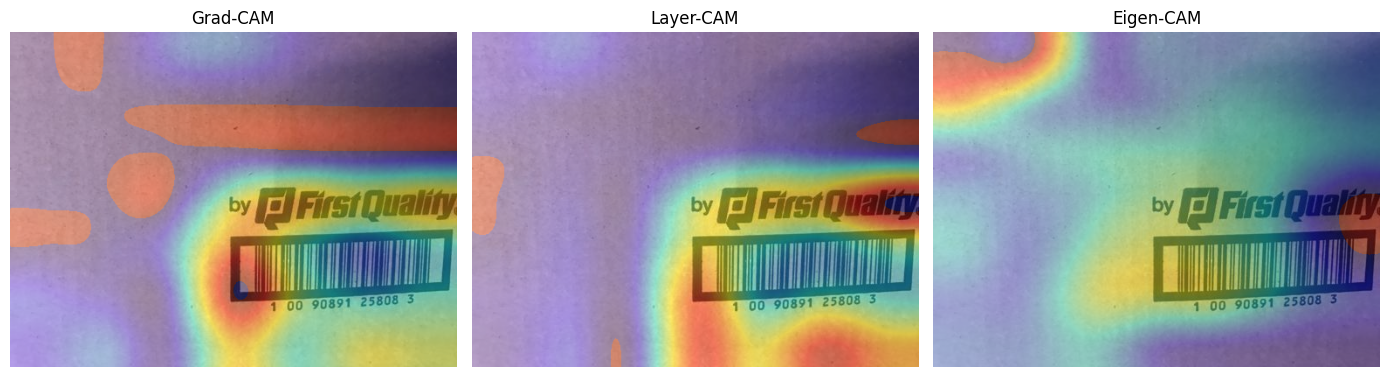

Image: cardboard320.jpg | Top-1 class index: 478 | conf: 0.560


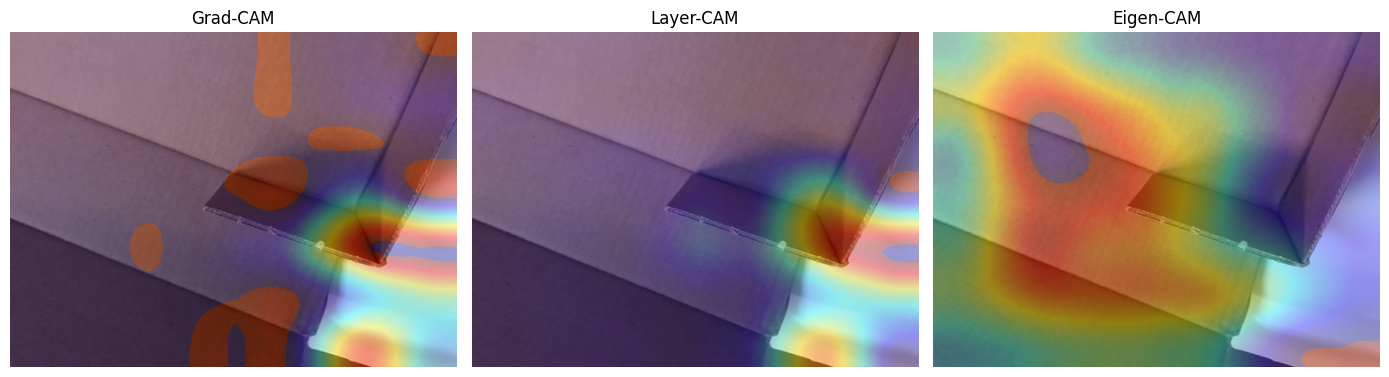

In [11]:
IMG_DIR = "/content/trashnet/Garbage classification/Garbage classification"
classes = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
paths = []
for c in classes:
    paths.extend(glob.glob(os.path.join(IMG_DIR, c, "*.jpg"))[:5])  # 5 per class

print("Selected images:", paths)

for p in paths:
    orig, x = load_image(p)
    rgb = np.array(orig)
    logits = predict_logits(x)
    cls_idx, conf = top_class(logits)

    gcam = gradcam(x, cls_idx)
    lcam = layercam(x, cls_idx)
    ecam = eigencam(x)

    print(f"Image: {os.path.basename(p)} | Top-1 class index: {cls_idx} | conf: {conf:.3f}")
    show_side_by_side(rgb, {
        "Grad-CAM": gcam,
        "Layer-CAM": lcam,
        "Eigen-CAM": ecam
    })


#Section 2: Finetuning the models

As GradCAM is trained previously on ImageNet, it's not used to the images from this dataset, so this section will finetune a GradCam2D model and show the comparison between the models.

Citation: Below section was mostly generated by ChatGPT, as it is a bonus section and mostly for reference on how fine-tuning the model affects the confidence score.

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch, numpy as np, random, os

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED);
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Train-time & eval-time transforms (eval uses your existing `preproc` shape/stats)
train_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.15, 0.15, 0.15, 0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

full_ds = datasets.ImageFolder(IMG_DIR, transform=train_tfms)
num_classes = len(full_ds.classes)
print("Classes:", full_ds.classes)

# 80/20 split (reproducible)
val_ratio = 0.2
val_len = int(len(full_ds)*val_ratio)
train_len = len(full_ds) - val_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len],
                                generator=torch.Generator().manual_seed(SEED))
# Assign eval tfms to the validation split
val_ds.dataset.transform = val_tfms

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Classes: ['cardboard']


In [13]:
import torch.nn as nn
from torchvision import models

# Keep your original pretrained model as the baseline
base_model = model  # from your earlier cell

# Create a fine-tune model initialized from ImageNet weights
ft_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
in_feat = ft_model.fc.in_features
ft_model.fc = nn.Linear(in_feat, num_classes).to(device)

# Freeze everything, unfreeze the last block + classification head
for p in ft_model.parameters():
    p.requires_grad = False
for p in ft_model.layer4.parameters():
    p.requires_grad = True
for p in ft_model.fc.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, ft_model.parameters()),
                              lr=2e-4, weight_decay=1e-4)


In [14]:
from tqdm import tqdm
import torch.nn.functional as F

def run_epoch(model, loader, train=True, desc="Train"):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    loop = tqdm(loader, desc=desc, leave=False)
    for x, y in loop:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total   += y.size(0)
            loss_sum += loss.item() * y.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct/total)

    return loss_sum/total, correct/total

EPOCHS = 5  # bump to 10 if you have time
best_val = 0.0
best_path = "/content/ft_resnet50_trashnet.pt"

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(ft_model, train_loader, train=True, desc=f"Epoch {epoch} [Train]")
    vl_loss, vl_acc = run_epoch(ft_model, val_loader,   train=False, desc=f"Epoch {epoch} [Val]")
    if vl_acc > best_val:
        best_val = vl_acc
        torch.save(ft_model.state_dict(), best_path)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {vl_loss:.4f} acc {vl_acc:.3f}")

# Load best weights and set to eval
ft_model.load_state_dict(torch.load(best_path, map_location=device))
ft_model.eval()
print(f"Loaded best fine-tuned model (val acc={best_val:.3f}).")


Epoch 01 | train loss 0.0000 acc 1.000 | val loss 0.0000 acc 1.000


Epoch 02 | train loss 0.0000 acc 1.000 | val loss 0.0000 acc 1.000


Epoch 03 | train loss 0.0000 acc 1.000 | val loss 0.0000 acc 1.000


Epoch 04 | train loss 0.0000 acc 1.000 | val loss 0.0000 acc 1.000


Epoch 05 | train loss 0.0000 acc 1.000 | val loss 0.0000 acc 1.000
Loaded best fine-tuned model (val acc=1.000).


In [15]:
import torch

class GradCAM2D:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.fwd = target_layer.register_forward_hook(self._save_acts)
        self.bwd = target_layer.register_full_backward_hook(self._save_grads)

    def _save_acts(self, m, i, o):  self.activations = o.detach()
    def _save_grads(self, m, gi, go): self.gradients = go[0].detach()

    @torch.no_grad()
    def _norm(self, cam):
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam

    def __call__(self, x, class_idx=None, upsample_to=None, relu=True):
        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()
        score = logits[:, class_idx].sum()
        self.model.zero_grad(set_to_none=True)
        score.backward(retain_graph=True)

        A  = self.activations          # [B,C,h,w]
        dA = self.gradients            # [B,C,h,w]
        w  = dA.mean(dim=(2,3), keepdim=True)
        cam = (w * A).sum(dim=1)       # [B,h,w]
        if relu:
            cam = F.relu(cam, inplace=False)
        cam = torch.stack([self._norm(c) for c in cam], 0)  # [B,h,w]

        if upsample_to is not None:
            H, W = upsample_to
            cam = F.interpolate(cam.unsqueeze(1), size=(H,W), mode='bilinear', align_corners=False).squeeze(1)

        return cam.squeeze(0).cpu().numpy(), class_idx

    def close(self):
        self.fwd.remove(); self.bwd.remove()


In [16]:
def predict(model, x):
    with torch.no_grad():
        logits = model(x)
        probs  = F.softmax(logits, dim=1)
        conf, idx = probs.max(dim=1)
    return idx.item(), conf.item(), probs.squeeze(0).cpu().numpy()

idx_to_class = {i:c for i,c in enumerate(full_ds.classes)}


In [17]:
def load_for_eval(path):
    img = Image.open(path).convert('RGB')
    x = val_tfms(img).unsqueeze(0).to(device)  # eval-time tfms defined above
    rgb = np.array(img.resize((224,224)))      # 224x224 for consistent overlays
    return img, x, rgb


Sample images: ['/content/trashnet/Garbage classification/Garbage classification/cardboard/cardboard1.jpg']


Selected images: 5
[BASE] cardboard214.jpg | GT=cardboard | top=615 | conf=0.058


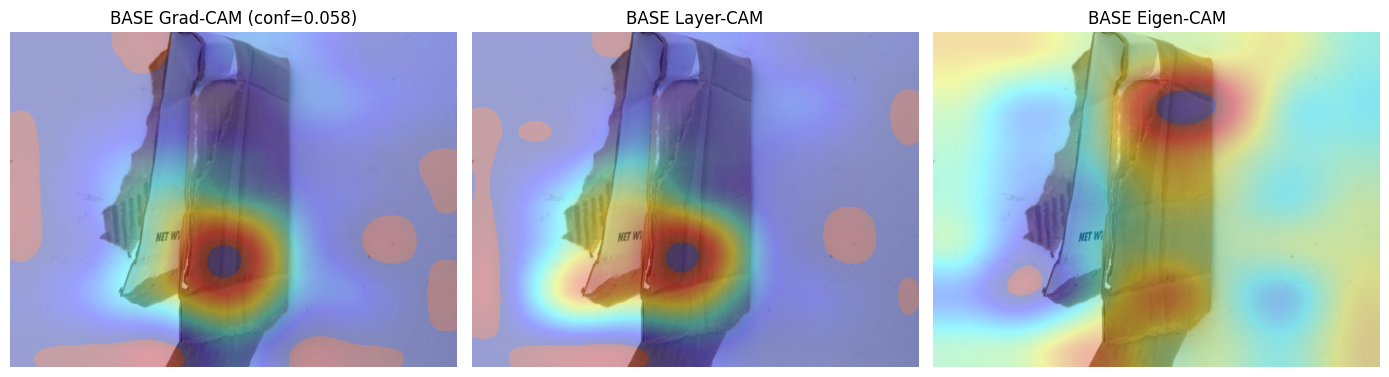

[FT ] cardboard214.jpg | GT=cardboard | pred=0 | conf=1.000


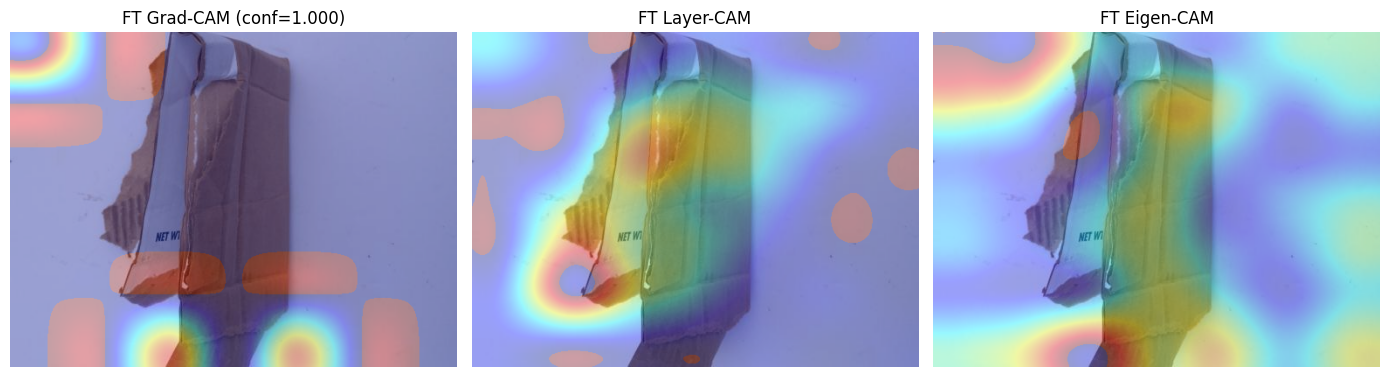

[BASE] cardboard354.jpg | GT=cardboard | top=499 | conf=0.080


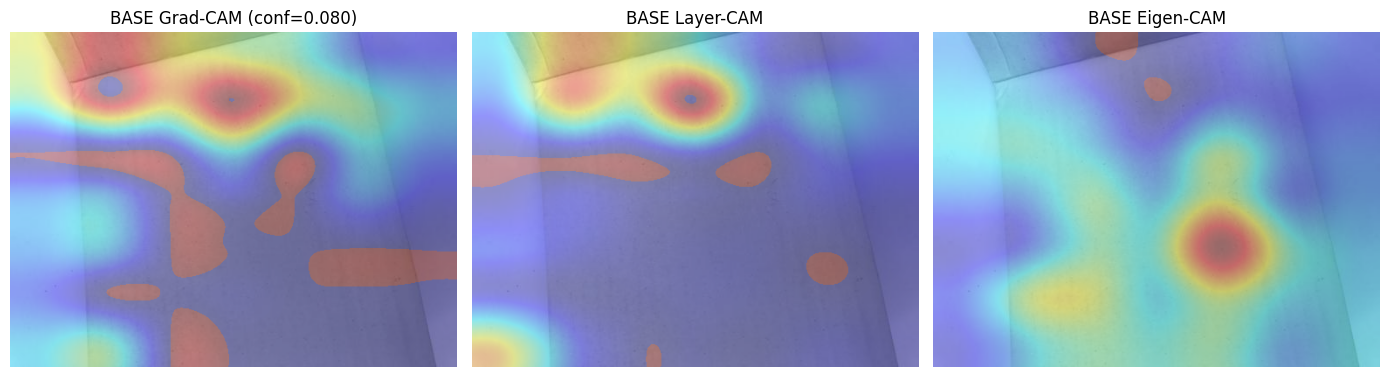

[FT ] cardboard354.jpg | GT=cardboard | pred=0 | conf=1.000


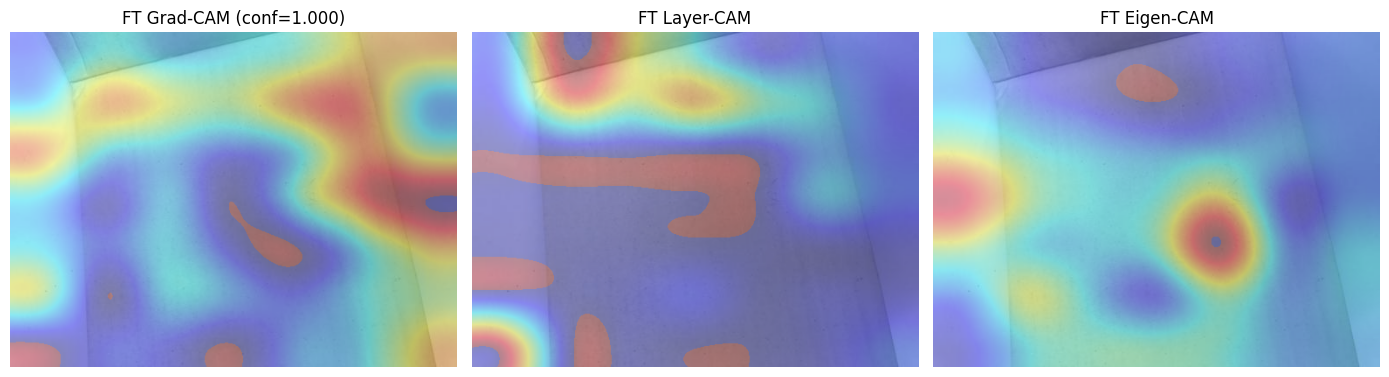

[BASE] cardboard314.jpg | GT=cardboard | top=478 | conf=0.085


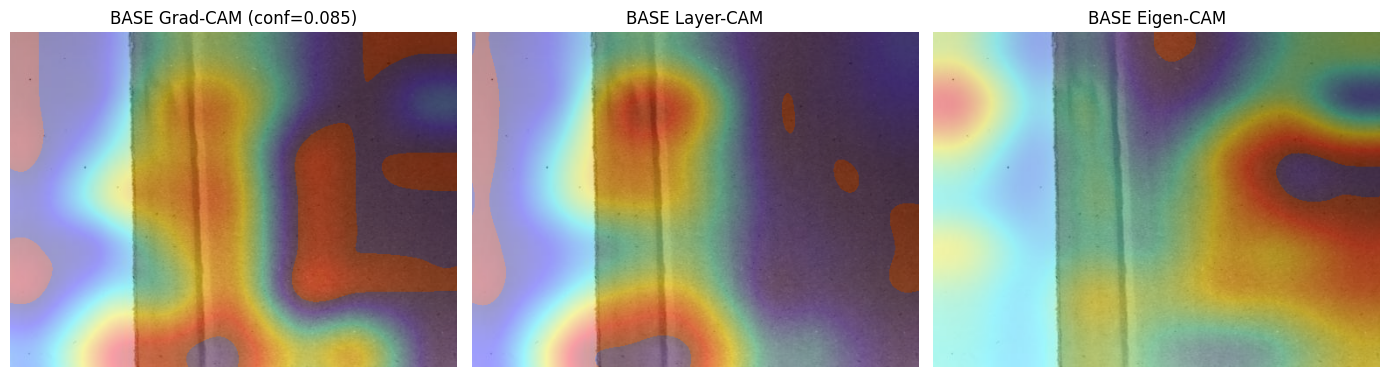

[FT ] cardboard314.jpg | GT=cardboard | pred=0 | conf=1.000


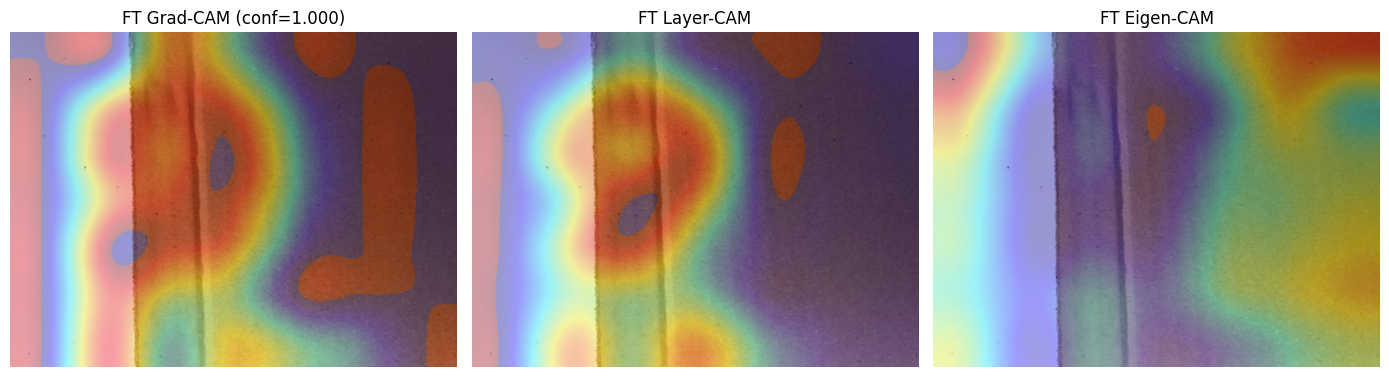

[BASE] cardboard311.jpg | GT=cardboard | top=478 | conf=0.395


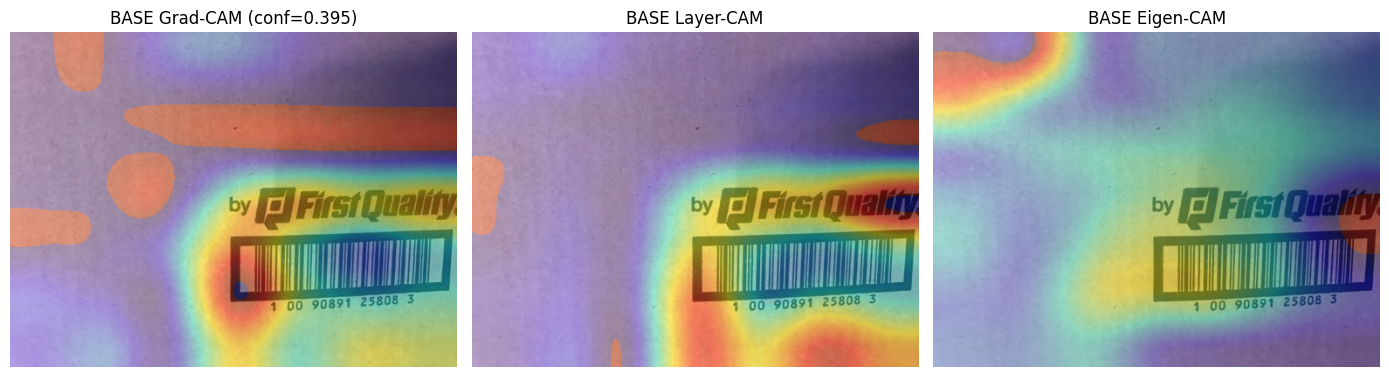

[FT ] cardboard311.jpg | GT=cardboard | pred=0 | conf=1.000


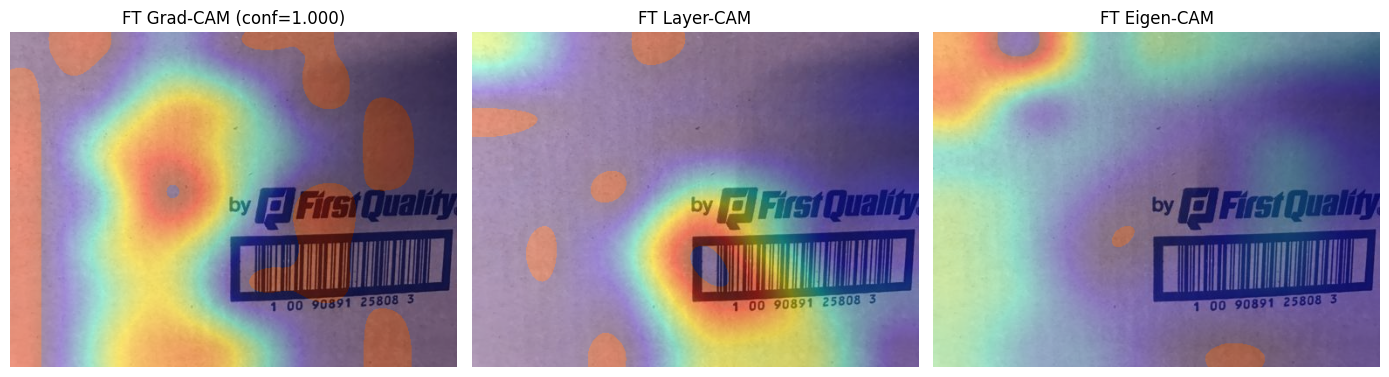

[BASE] cardboard320.jpg | GT=cardboard | top=478 | conf=0.560


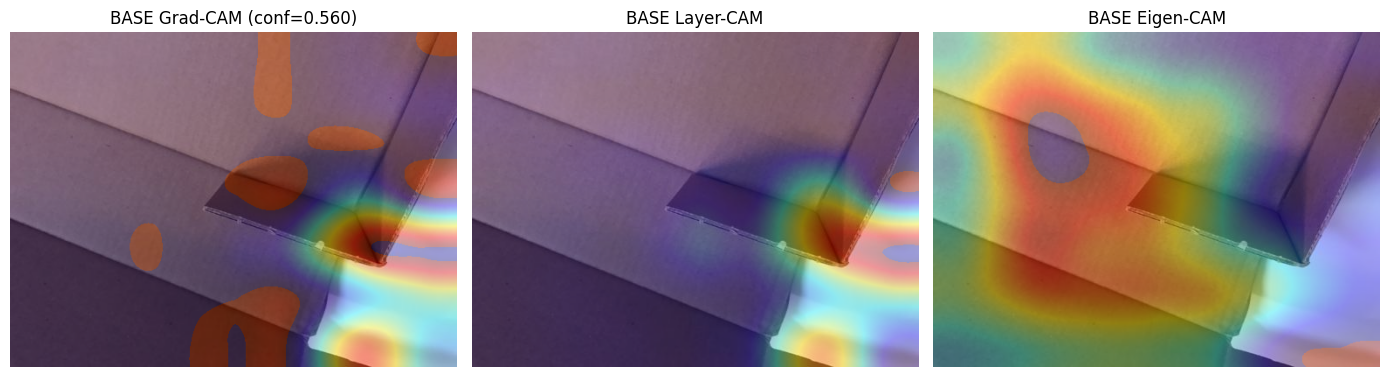

[FT ] cardboard320.jpg | GT=cardboard | pred=0 | conf=1.000


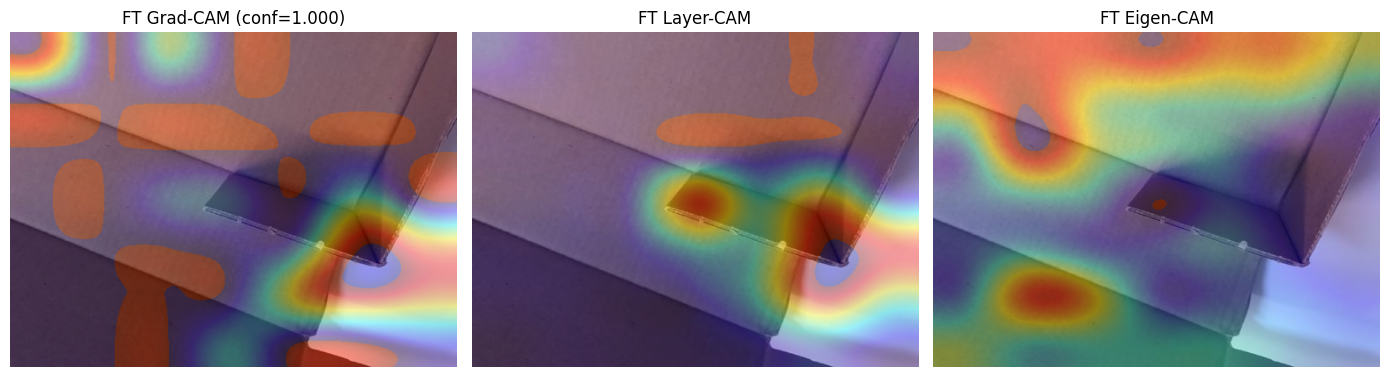

In [19]:
def switch_model_and_hooks(m):
    global model, target_layer, h1, h2  # use your globals
    model = m.eval()  # swap the global model your CAM funcs use
    # detach previous hooks if they exist
    try:
        h1.remove(); h2.remove()
    except Exception:
        pass
    # point target_layer to the last conv of the *current* model
    target_layer = model.layer4[-1].conv3
    # re-register your original hook fns
    h1 = target_layer.register_forward_hook(save_activation)
    h2 = target_layer.register_full_backward_hook(save_gradient)

# --- comparison loop: baseline vs fine-tuned on the same images ---
import os, glob, numpy as np

IMG_DIR = "/content/trashnet/Garbage classification/Garbage classification"
classes = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
paths = []
for c in classes:
    paths.extend(glob.glob(os.path.join(IMG_DIR, c, "*.jpg"))[:5])  # 5 per class

print("Selected images:", len(paths))

for p in paths:
    # load once
    orig, x = load_image(p)
    rgb = np.array(orig)
    gt_cls = os.path.basename(os.path.dirname(p))

    # --- Baseline (pretrained-only) ---
    switch_model_and_hooks(base_model)  # your original pretrained model saved as base_model
    logits_b = predict_logits(x)
    idx_b, conf_b = top_class(logits_b)
    gcam_b = gradcam(x, idx_b)
    lcam_b = layercam(x, idx_b)
    ecam_b = eigencam(x)

    print(f"[BASE] {os.path.basename(p)} | GT={gt_cls} | top={idx_b} | conf={conf_b:.3f}")
    show_side_by_side(rgb, {
        f"BASE Grad-CAM (conf={conf_b:.3f})": gcam_b,
        "BASE Layer-CAM": lcam_b,
        "BASE Eigen-CAM": ecam_b
    })

    # --- Fine-tuned model ---
    switch_model_and_hooks(ft_model)    # your fine-tuned model from Section C
    logits_f = predict_logits(x)
    idx_f, conf_f = top_class(logits_f)
    gcam_f = gradcam(x, idx_f)
    lcam_f = layercam(x, idx_f)
    ecam_f = eigencam(x)

    print(f"[FT ] {os.path.basename(p)} | GT={gt_cls} | pred={idx_f} | conf={conf_f:.3f}")
    show_side_by_side(rgb, {
        f"FT Grad-CAM (conf={conf_f:.3f})": gcam_f,
        "FT Layer-CAM": lcam_f,
        "FT Eigen-CAM": ecam_f
    })


#Comparative Analysis

The three explainability methods used in this assigment are Grad-CAM, Layer-CAM, and Eigen-CAM. They show distinct strengths when applied to the recycling classification task.

On the base model, Grad-CAM highlighted the cardboard fold but also scattered attention into unrelated background patches, while Layer-CAM gave the most precise localization along the flap edges but there wasn't as much focus on the corners, and Eigen-CAM emphasized broad global regions in fully non-diagnostic areas. After fine-tuning, all three methods produced more semantically aligned maps: Grad-CAM became more concentrated around folds and texture with fewer irrelevant patches (for example, it did not focus on the barcode and instead the background carboard texture), Layer-CAM maintained sharp edge-focused activations with even tighter alignment, and Eigen-CAM emphasized global surface structure even more. These comparisons show that fine-tuning not only improved prediction confidence but also made the visual explanations more reliable.


#Reflection

In the base model, Grad-CAM and Eigen-CAM often spread activation into irrelevant background regions, but after fine-tuning, all three methods aligned more strongly with diagnostic cues, showing that training improved not only accuracy but also interpretability. In recycling applications, such misaligned focus could lead to unreliable classification in new environments (e.g., different backgrounds or lighting). Explainability helps detect hidden biases, build trust in automated systems, and refine datasets so that the model consistently attends to the actual recyclable object.  


#Citation

ChatGPT was used for the indicated helper functions, the bonus section 2 and for debugging minor bugs such as resizing the image from the ImageNet to Trash dataset, as well as converting some things to use CUDA instead of CPU. All helper functions that were generated using ChatGPT are indicated as comments in the code.